In [1]:
import os 
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
    device_name="/CPU:0"
print('device is : {}'.format(device_name))

/device:GPU:0
device is : /device:GPU:0


In [0]:
data=np.load("drive/My Drive/data/shots.npz")

In [0]:
shots=data["shots"]
labels=data["labels"]
keys=data["keys"]
vals=data["vals"]


In [7]:
pd.DataFrame({"videos":keys,"frames":vals})

,videos,frames
0,63000,441
1,63008,735
2,63009,1175
3,62625,1527
4,62629,1807
5,62700,2247
6,62701,2687
7,62720,3127
8,64000,3171
9,63540,3523


In [8]:
# Changing the labels to match the x point classification
labels[4506:5642]=0

# Selected validation videos
validation_index=np.concatenate((np.arange(5202,5642),np.arange(6478,6830),np.arange(7182,7622),np.arange(7959,8303)))
validation_index.shape

(1576,)

In [0]:
ratio=0.5
# set up a mask to subset the training set
mask = np.ones(len(labels), np.bool)
mask[validation_index] = 0

# seperating validation set
x_tr=shots[mask]
x_te=shots[validation_index]
y_tr=labels[mask]
y_te=labels[validation_index]

# Reducing overfitting by remove shots where we both have the outer leg and the x point
# set seed
np.random.seed(1)

# generate random indices
num_row = len(y_tr)
indices = np.random.permutation(num_row)
index_split = int(np.floor(ratio * num_row))
index_kept = indices[: index_split]
# reducing train size
x_tr=x_tr[index_kept]
y_tr=y_tr[index_kept]
# splitting the rest to train / test sets
#x_tr, x_te, y_tr, y_te=split_data(shots_train,labels_train,ratio)


In [10]:
y_tr.shape, y_te.shape 

((3715,), (1576,))

In [11]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
with tf.device(device_name):
  base_model = tf.keras.models.load_model('drive/My Drive/data/trained_model.h5')
  base_model.trainable = False
  base_model.pop()
  base_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
  base_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      1952      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        61984     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 3

In [12]:

with tf.device(device_name):
  x = base_model.output
  x = layers.Dense(1, activation='sigmoid', name="dense_3")(x)

  model_3 = Model(inputs=base_model.input, outputs=x)
  model_3.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
  model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      1952      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        61984     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               419443

Text(0.5, 1.0, 'Shot where we see the outer leg but not the x point')

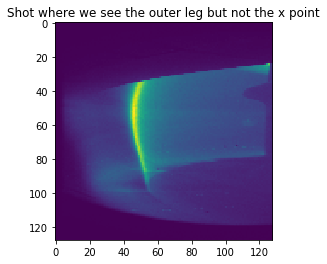

In [13]:
plt.imshow(shots[5000,:,:,0])
plt.title("Shot where we see the outer leg but not the x point")

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./4096, 
                                           rotation_range=30,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           shear_range=10,
                                           zoom_range=0.1,
                                           horizontal_flip=True,
                                          )
validation_image_generator = ImageDataGenerator(rescale=1./4096)

train_data_gen = train_image_generator.flow(x_tr,y_tr)
val_data_gen = validation_image_generator.flow(x_te,y_te)

In [14]:
total_train=int(x_tr.shape[0])
total_val=int(x_te.shape[0])
epochs = 50
batch_size=128
#with tf.device('/device:GPU:0'):
history=model_3.fit_generator(
              train_data_gen,
              steps_per_epoch=total_train // batch_size,
              epochs=epochs,
              validation_data=val_data_gen,
              
              validation_steps=total_val // batch_size
          )

Epoch 1/50
29/29 [==============================] - 7s 252ms/step - loss: 0.3900 - acc: 0.8351 - val_loss: 0.4535 - val_acc: 0.7917
Epoch 2/50
29/29 [==============================] - 1s 41ms/step - loss: 0.3230 - acc: 0.8588 - val_loss: 0.4583 - val_acc: 0.8411
Epoch 3/50
29/29 [==============================] - 1s 41ms/step - loss: 0.2409 - acc: 0.8987 - val_loss: 0.4812 - val_acc: 0.8542
Epoch 4/50
29/29 [==============================] - 1s 40ms/step - loss: 0.3141 - acc: 0.8743 - val_loss: 0.3937 - val_acc: 0.8542
Epoch 5/50
29/29 [==============================] - 1s 43ms/step - loss: 0.2712 - acc: 0.8836 - val_loss: 0.3508 - val_acc: 0.8568
Epoch 6/50
29/29 [==============================] - 1s 43ms/step - loss: 0.2613 - acc: 0.8901 - val_loss: 0.3251 - val_acc: 0.8620
Epoch 7/50
29/29 [==============================] - 1s 41ms/step - loss: 0.2460 - acc: 0.9021 - val_loss: 0.2841 - val_acc: 0.8620
Epoch 8/50
29/29 [==============================] - 1s 42ms/step - loss: 0.2648 - 

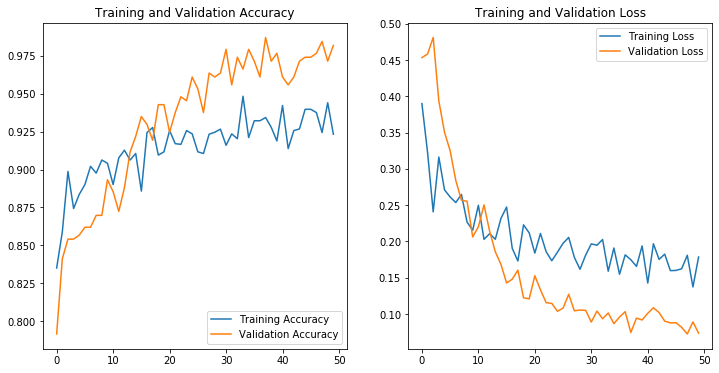

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on validation set')
results = model_3.evaluate(x_te, y_te, batch_size=batch_size)
print('test loss, test acc:', results)


# Evaluate on validation set
1576/1576 [==============================] - 0s 275us/sample - loss: 171.6283 - acc: 0.9454
test loss, test acc: [171.62827118278156, 0.9454315]


Without Transfer Learning

In [0]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
with tf.device(device_name):
  new_model = Sequential([
        Conv2D(16, 11, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
        MaxPooling2D(),
        Conv2D(32, 11, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        
        Dense(1, activation='sigmoid')
    ])
  new_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [18]:
history=new_model.fit_generator(
              train_data_gen,
              steps_per_epoch=total_train // batch_size,
              epochs=50,
              validation_data=val_data_gen,
              
              validation_steps=total_val // batch_size
          )

Epoch 1/50
29/29 [==============================] - 2s 62ms/step - loss: 0.5579 - acc: 0.8103 - val_loss: 0.4937 - val_acc: 0.8047
Epoch 2/50
29/29 [==============================] - 1s 42ms/step - loss: 0.3599 - acc: 0.8405 - val_loss: 0.1650 - val_acc: 0.9688
Epoch 3/50
29/29 [==============================] - 1s 43ms/step - loss: 0.2802 - acc: 0.8782 - val_loss: 0.1822 - val_acc: 0.9531
Epoch 4/50
29/29 [==============================] - 1s 43ms/step - loss: 0.3007 - acc: 0.8699 - val_loss: 0.2010 - val_acc: 0.9062
Epoch 5/50
29/29 [==============================] - 1s 47ms/step - loss: 0.2405 - acc: 0.8879 - val_loss: 0.0907 - val_acc: 0.9688
Epoch 6/50
29/29 [==============================] - 1s 44ms/step - loss: 0.2575 - acc: 0.8804 - val_loss: 0.0827 - val_acc: 0.9792
Epoch 7/50
29/29 [==============================] - 1s 43ms/step - loss: 0.2676 - acc: 0.9132 - val_loss: 0.1875 - val_acc: 0.9167
Epoch 8/50
29/29 [==============================] - 1s 44ms/step - loss: 0.1905 - a

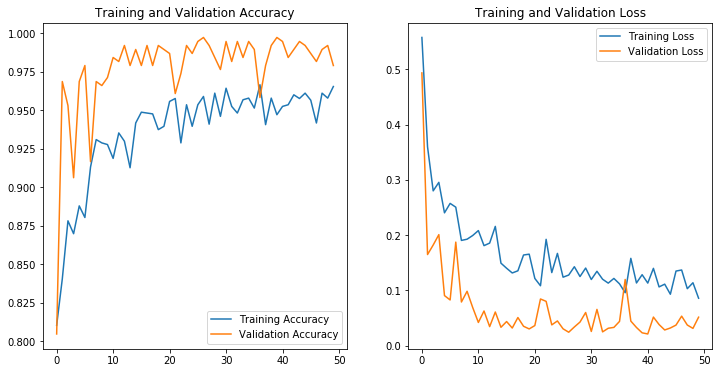

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
print('\n# Evaluate on validation set')
results = new_model.evaluate(x_te, y_te, batch_size=batch_size)
print('test loss, test acc:', results)


# Evaluate on validation set
1576/1576 [==============================] - 0s 139us/sample - loss: 168.0236 - acc: 0.9492
test loss, test acc: [168.0235539934962, 0.9492386]
